In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

submission = pd.read_csv('scaled_submission_Gwangjin_10years_feature_inportance_gs_without_seasonal(interest).csv')
inversed_submission = pd.read_csv('inversed_submission_Gwangjin_10years_feature_inportance_gs_without_seasonal(interest).csv')

wl = pd.read_csv('Han River Flood Hazard Standard Water Level.csv')
wl.rename(columns={'observatory': 'bridge_name'}, inplace=True)

C:\Users\chaemin\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
submission = pd.merge(submission, wl, on='bridge_name', how='left')
inversed_submission = pd.merge(inversed_submission, wl, on='bridge_name', how='left')

In [6]:
inversed_submission['anomaly'] = inversed_submission['true'] >= inversed_submission['interest']
inversed_submission

,datetime,true,predict,bridge_name,anomaly,interest,attention,caution,serious,latitude,longitude
0,2022-01-01 08:00:00,1.02,1.023297,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
1,2022-01-01 09:00:00,1.02,1.033383,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
2,2022-01-01 10:00:00,1.02,1.027878,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
3,2022-01-01 11:00:00,1.02,1.027904,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
4,2022-01-01 12:00:00,1.02,1.021068,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
...,...,...,...,...,...,...,...,...,...,...,...
17507,2023-12-31 19:00:00,1.13,1.129770,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
17508,2023-12-31 20:00:00,1.13,1.117293,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
17509,2023-12-31 21:00:00,1.13,1.118361,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
17510,2023-12-31 22:00:00,1.13,1.124618,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154


In [7]:
from sklearn.metrics import roc_curve, auc
def confusion_matrix(submission):
    confusion_df = pd.DataFrame()
    confusion_df['true'] = submission['true'] >= submission['interest'].iloc[0]
    confusion_df['predict'] = submission['predict'] >= submission['interest'].iloc[0]

    # TP, TN, FP, FN 계산
    TP = ((confusion_df['true'] == True) & (confusion_df['predict'] == True)).sum()
    TN = ((confusion_df['true'] == False) & (confusion_df['predict'] == False)).sum()
    FP = ((confusion_df['true'] == False) & (confusion_df['predict'] == True)).sum()
    FN = ((confusion_df['true'] == True) & (confusion_df['predict'] == False)).sum()

    print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
    # 정밀도 (Precision)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # 재현율 (Recall)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1 점수 (F1 Score)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # 결과 출력
    print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}')

    # ROC curve 계산
    fpr, tpr, _ = roc_curve(confusion_df['true'], confusion_df['predict'])
    roc_auc = auc(fpr, tpr)

    # ROC curve 그래프
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

TP: 223, TN: 17284, FP: 4, FN: 1
Precision: 0.98, Recall: 1.00, F1 Score: 0.99


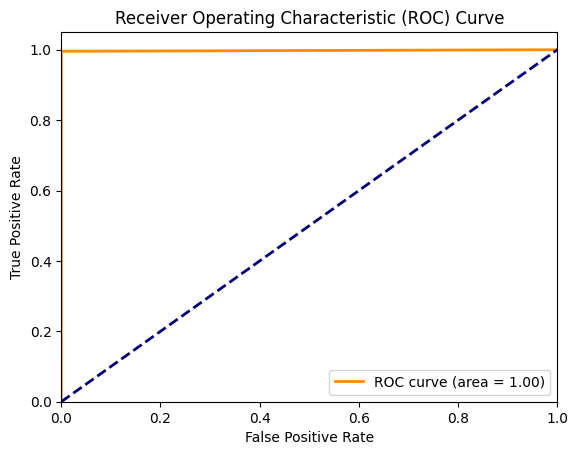

In [8]:
confusion_matrix(inversed_submission)

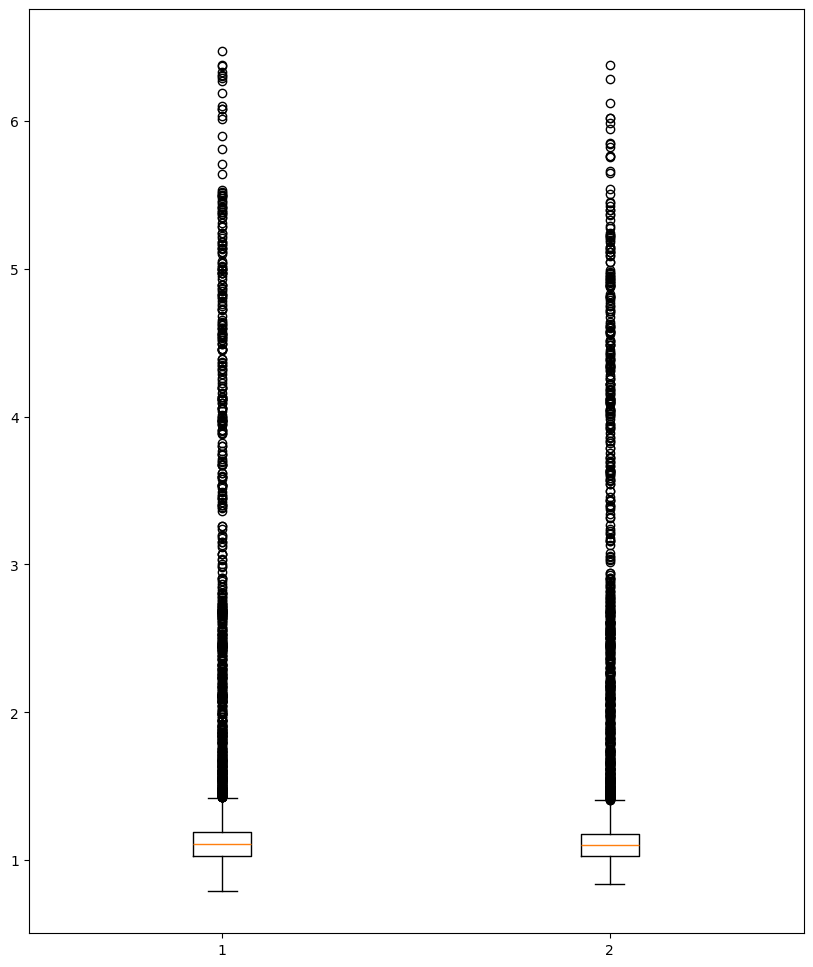

In [9]:
plt.figure(figsize=(10,12))
plt.boxplot(inversed_submission[['true', 'predict']])
plt.show()

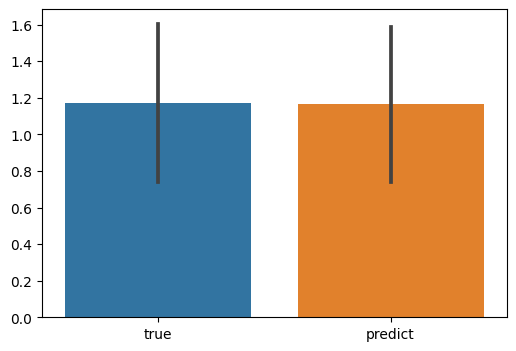

In [10]:
plt.figure(figsize=(6,4))
sns.barplot(inversed_submission[['true', 'predict']], ci='sd')
plt.show()

In [11]:
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

def evaluation(submission):
    eval = pd.DataFrame(columns=['bridge_name','anomaly_ratio(%)','R-squared', 'R-squared_adj','MAE','MSE','RMSE'])
    i=0
    for bridge in submission['bridge_name'].unique(): 
        df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge]
    #     df_anomaly = df[df['anomaly'] ==True]
        df_anomaly = df_bridge[df_bridge['interest'] < df_bridge['true']]

        true_values = df_anomaly['true']
        predicted_values = df_anomaly['predict']
        anomaly_ratio = round(len(df_anomaly)/len(df_bridge) * 100, 2)
        r_squared = r2_score(true_values, predicted_values)
        mae = mean_absolute_error(true_values, predicted_values)
        mse = mean_squared_error(true_values, predicted_values)
        rmse = np.sqrt(mse)
        msle = mean_squared_log_error(true_values, predicted_values)
        rmsle = np.sqrt(msle)
        
        
        n = len(true_values)
        p = 9
        adjusted_r2 = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

        eval.loc[i, 'anomaly_ratio(%)'] = anomaly_ratio
        eval.loc[i, 'bridge_name'] = bridge
        eval.loc[i, 'R-squared'] = r_squared
        eval.loc[i, 'R-squared_adj'] = adjusted_r2
        eval.loc[i, 'MAE'] = mae
        eval.loc[i, 'MSE'] = mse
        eval.loc[i, 'RMSE'] = rmse
        eval.loc[i, 'MSLE'] = msle
        eval.loc[i, 'RMSLE'] = rmsle
        
        i += 1
    return eval

def visualization_anomaly(submission):
    length = len(submission['bridge_name'].unique())
    fig, axs = plt.subplots(length, 1, figsize=(15, 6*length))

    for i, bridge in enumerate(submission['bridge_name'].unique()):
        df_bridge = submission[submission['bridge_name'] == bridge].reset_index(drop=True)
        df_bridge.set_index('datetime', inplace=True)
        anomaly = df_bridge[df_bridge['interest'] < df_bridge['true']]
    
        axs[i].scatter(anomaly.index, anomaly['true'], marker='x', label='True')
        axs[i].scatter(anomaly.index, anomaly['predict'], marker='o',label='Predict') 
        axs[i].set_title(bridge + ' anomaly only')
        axs[i].axhline(y=df_bridge['interest'].iloc[0], color='g', linestyle='--', label='interest')
#         axs[i].axhline(y=df_bridge['attention'].iloc[0], color='y', linestyle='--', label='attention')
#         axs[i].axhline(y=df_bridge['caution'].iloc[0], color='orange', linestyle='--', label='caution')
#         axs[i].axhline(y=df_bridge['serious'].iloc[0], color='r', linestyle='--', label='serious')
        axs[i].legend()
    plt.show()

In [12]:
evaluation(inversed_submission)

,bridge_name,anomaly_ratio(%),R-squared,R-squared_adj,MAE,MSE,RMSE,MSLE,RMSLE
0,Gwangjin Bridge,1.27,0.933575,0.930768,0.162199,0.045467,0.21323,0.00145,0.038079


In [13]:
submission

,datetime,true,predict,bridge_name,anomaly,interest,attention,caution,serious,latitude,longitude
0,2022-01-01 08:00:00,-0.252543,-0.249069,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
1,2022-01-01 09:00:00,-0.252543,-0.238443,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
2,2022-01-01 10:00:00,-0.252543,-0.244243,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
3,2022-01-01 11:00:00,-0.252543,-0.244216,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
4,2022-01-01 12:00:00,-0.252543,-0.251417,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
...,...,...,...,...,...,...,...,...,...,...,...
17507,2023-12-31 19:00:00,-0.136658,-0.136900,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
17508,2023-12-31 20:00:00,-0.136658,-0.150044,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
17509,2023-12-31 21:00:00,-0.136658,-0.148919,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154
17510,2023-12-31 22:00:00,-0.136658,-0.142328,Gwangjin Bridge,False,3.0,8.0,10.5,13.6,37.54295,127.113154


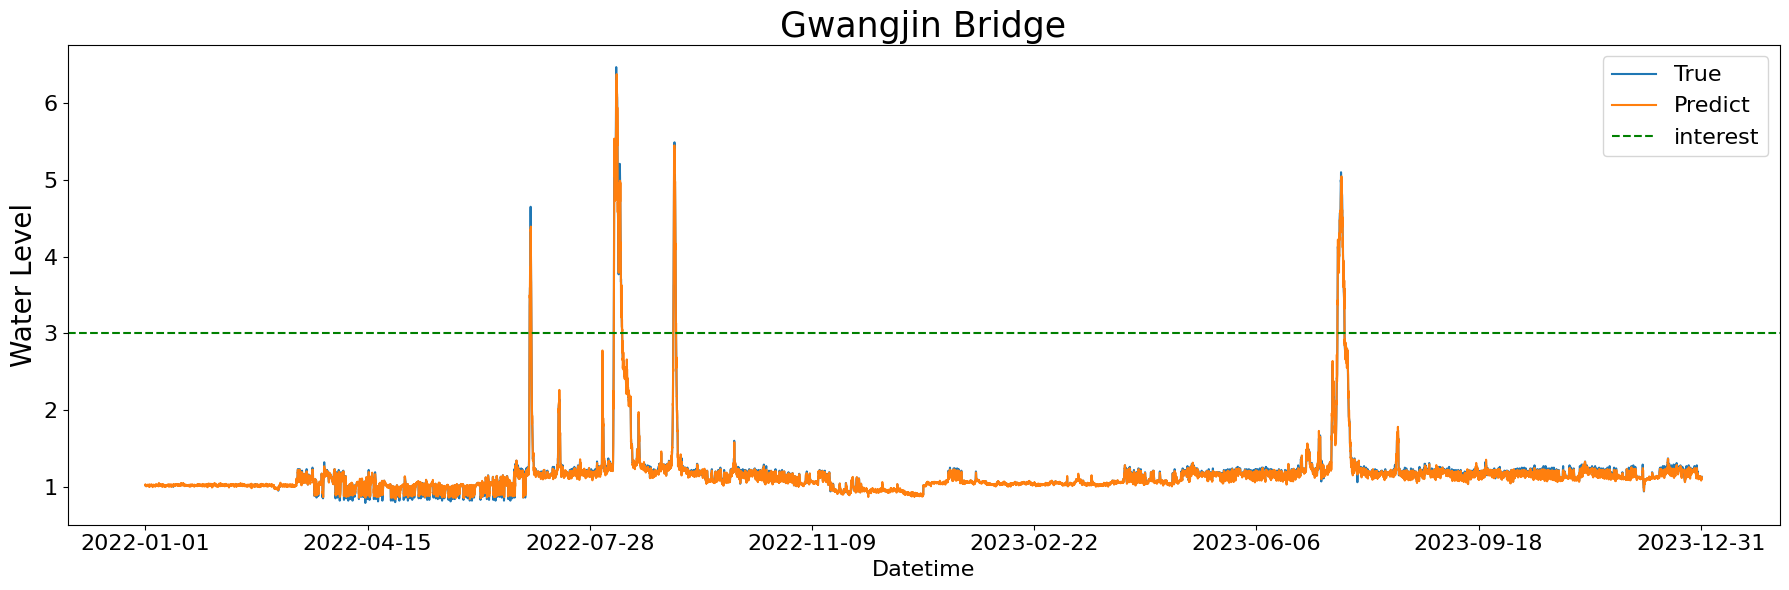

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(18, 6))  # 그림의 크기를 너비 18인치, 높이 6인치로 설정

bridge = 'Gwangjin Bridge'
df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge].reset_index(drop=True)
df_bridge.set_index('datetime', inplace=True)

anomaly = df_bridge[df_bridge['interest'] < df_bridge['true']]
dates = pd.to_datetime(df_bridge.index)

# 선 그래프 그리기
plt.plot(dates, df_bridge['true'], label='True', linestyle='solid')
plt.plot(dates, df_bridge['predict'], label='Predict', linestyle='solid')

plt.title(bridge, fontsize=25)
plt.axhline(y=df_bridge['interest'].iloc[0], color='g', linestyle='--', label='interest')

# 원하는 형식으로 날짜 포맷 지정
plt.xticks(dates[::2500], labels=dates.strftime('%Y-%m-%d')[::2500], fontsize=16)
plt.yticks(fontsize=16)  # y축 눈금 폰트 사이즈 설정
plt.xlabel('Datetime', fontsize=16)  # x축 레이블 폰트 사이즈 설정
plt.ylabel('Water Level', fontsize=20)    # y축 레이블 폰트 사이즈 설정
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()


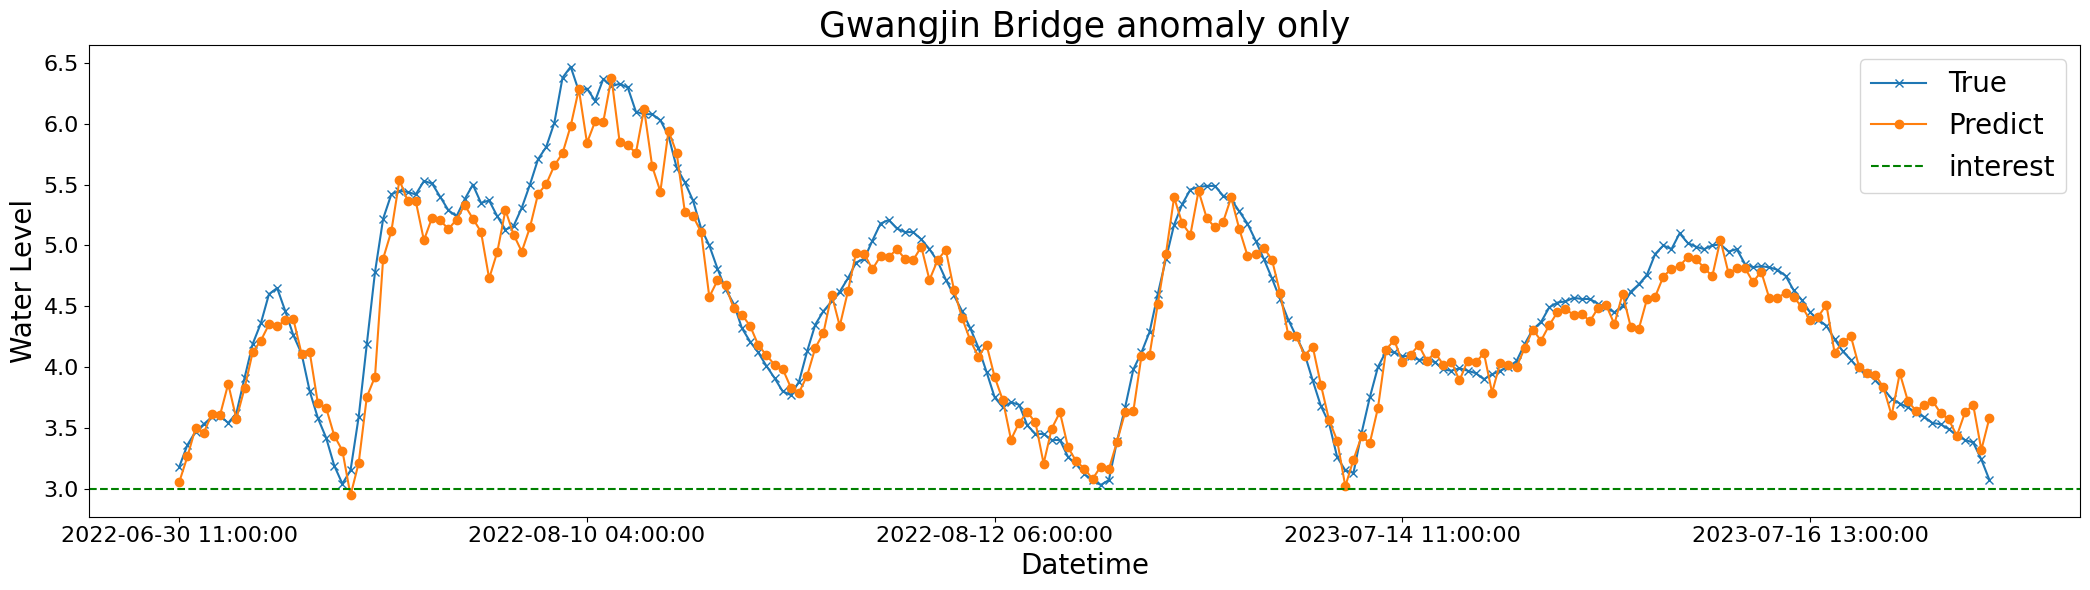

In [34]:
plt.figure(figsize=(21, 6))  # 그림의 크기를 너비 10인치, 높이 6인치로 설정
bridge = 'Gwangjin Bridge'
df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge].reset_index(drop=True)
df_bridge.set_index('datetime', inplace=True)
anomaly = df_bridge[df_bridge['interest'] < df_bridge['true']]
    
plt.plot(anomaly.index, anomaly['true'], marker='x', label='True', linestyle='solid')
plt.plot(anomaly.index, anomaly['predict'], marker='o',label='Predict',linestyle='solid') 
plt.title(bridge + ' anomaly only', fontsize=25)



plt.axhline(y=df_bridge['interest'].iloc[0], color='g', linestyle='--', label='interest')
plt.xticks(anomaly.index[::50], fontsize=16)  # x축 눈금 폰트 사이즈 설정
plt.yticks(fontsize=16)  # y축 눈금 폰트 사이즈 설정
plt.xlabel('Datetime', fontsize=20)  # x축 레이블 폰트 사이즈 설정
plt.ylabel('Water Level', fontsize=20)    # y축 레이블 폰트 사이즈 설정

plt.legend(fontsize=20)
plt.tight_layout()
plt.show()
